# Обучение нейронных сетей

Сеть, которую мы построили в предыдущей части, пока не обучена. Нейронные сети с нелинейными активациями работают как универсальные аппроксиматоры функций. Существует некоторый функционал, который отображает ваш ввод на выход. Например, изображения рукописных цифр на вероятности классов. Сила нейронных сетей заключается в том, что мы можем их обучить для аппроксимации этой функции, а в принципе любой функции, если у нас достаточно данных и вычислительных ресурсов.

<img src="assets/function_approx.png" width=500px>

Сначала сеть является наивной, она не знает функцию, которая отображает входные данные на выходные. Мы обучаем сеть, показывая ей примеры реальных данных, а затем корректируя параметры сети, чтобы она приближала эту функцию.

Чтобы найти эти параметры, нам нужно знать, насколько плохо сеть предсказывает реальные выходы. Для этого мы вычисляем **функцию потерь** (loss function, cost), меру нашей ошибки предсказания. Например, среднеквадратическая функция потерь часто используется в задачах регрессии и бинарной классификации.

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

где $n$ — количество обучающих примеров, $y_i$ — истинные метки, а $\hat{y}_i$ — предсказанные метки.

Минимизируя эту потерю относительно параметров сети, мы можем найти конфигурации, где потери находятся на минимуме, и сеть может предсказывать правильные метки с высокой точностью. Мы находим этот минимум с помощью процесса, называемого **градиентным спуском**. Градиент — это наклон (slope) функции потерь и указывает в направлении самого быстрого изменения. Чтобы добраться до минимума за наименьшее время, мы хотим следовать градиенту (вниз). Вы можете представить это как спуск с горы, следуя по самым крутым склонам к подножию.

<img src='assets/gradient_descent.png' width=350px>

## Обратное распространение

Для сетей с одним слоем градиентный спуск легко реализовать. Однако для более глубоких многослойных нейронных сетей, таких как та, что мы построили, это более сложно. Достаточно сложно, что прошло около 30 лет, прежде чем исследователи поняли, как обучать многослойные сети.

Обучение многослойных сетей осуществляется с помощью **обратного распространения**, что на самом деле является лишь применением правила цепочки дифференцироввания сложной функции из матанализа. Легче всего понимать это, если мы преобразуем сеть из двух слоев в графическое представление.

<img src='assets/backprop_diagram.png' width=550px>

В прямом проходе через сеть наши данные и операции проходят снизу вверх. Мы пропускаем вход $x$ через линейное преобразование $L_1$ с весами $W_1$ и смещениями $b_1$. Выход затем проходит через сигмоиду $S$ и ещё одно линейное преобразование $L_2$. Наконец, мы вычисляем потерю $\ell$. Мы используем функцию потерь в качестве меры того, насколько плохи предсказания сети. Цель затем — настроить веса и смещения, чтобы минимизировать функцию потерь.

Чтобы обучить веса с помощью градиентного спуска, мы пропускаем градиент потерь назад через сеть. Каждая операция имеет некоторый градиент между входами и выходами. Отправляя градиенты назад, мы умножаем входящий градиент на градиент операции. Математически это на самом деле просто вычисление градиента потерь относительно весов с использованием правила цепочки.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**Примечание:** Здесь опускаются некоторые детали из векторного исчисления, но они не обязательны для общего понимания происходящего.

Мы обновляем наши веса, используя этот градиент с некоторой скоростью обучения $\alpha$.

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

Скорость обучения $\alpha$ выбирается таким образом, чтобы шаги обновления весов были достаточно малыми, чтобы итеративный метод сошелся на минимуме.

## Функции потерь в PyTorch

Давайте начнем с того, как мы вычисляем функцию потерь с помощью PyTorch. Через модуль `nn` PyTorch предоставляет функции потерь, например, кросс-энтропию (`nn.CrossEntropyLoss`). Обычно вы увидите, что потеря присваивается переменной `criterion`. Как было отмечено в последней части, при решении задач классификации, таких как в примере с MNIST, мы используем функцию softmax для предсказания вероятностей классов. С выводом softmax вы хотите использовать кросс-энтропию в качестве функции потерь. Чтобы действительно вычислить функцию потерь, вы сначала определяете критерий, а затем передаете выход вашей сети и правильные метки.

Что-то очень важное, о чем необходимо упомянуть. Обратимся к [документации для `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

Это значит, что нам нужно передать сырой выход нашей сети в функцию потерь, а не выход функции softmax. Этот сырой выход обычно называется *логитами* (logits) или *оценками* (scores). Мы используем логиты, поскольку softmax дает вам вероятности, которые часто бывают очень близкими к нулю или единице, но числа с плавающей точкой не могут точно представить значения, близкие к нулю или единице ([узнать больше здесь](https://docs.python.org/3/tutorial/floatingpoint.html)). Обычно лучше избегать вычислений с вероятностями, часто мы используем логарифмы вероятностей (log-probabilities).

In [1]:
# Наборы данных MNIST размещены на yann.lecun.com, который переместился под защиту CloudFlare
# Запустите этот скрипт, чтобы сделать возможной загрузку этого набора данных
# Ссылка: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Определим трансформацию для нормализации данных
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Загрузим обучающие данные
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

c:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\user1\anaconda3\envs\YOLO\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# Создадим сеть прямого распространения
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Определим функцию потерь
criterion = nn.CrossEntropyLoss()

# Получим наши данные
images, labels = next(iter(trainloader))
# Разворачиваем изображения
images = images.view(images.shape[0], -1)

# Прямой проход, получаем наши логиты
logits = model(images)
# Вычисляем функцию потерь, передавая логиты и истинные метки
loss = criterion(logits, labels)

print(loss)

tensor(2.3104, grad_fn=<NllLossBackward0>)


С другой стороны, удобнее построить модель с логарифмическим softmax выводом, используя `nn.LogSoftmax` или `F.log_softmax` ([документация](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Затем вы можете получить фактические вероятности, взяв экспоненту `torch.exp(output)`. С выводом логарифмического softmax вам необходимо использовать обратный логарифм правдоподобия (negative log likelihood loss), `nn.NLLLoss` ([документация](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

>**Упражнение:** Постройте модель, которая возвращает логарифмический softmax в качестве вывода и вычисляет функцию потерь, используя обратный логарифм правдоподобия.

In [19]:
## TODO

# Создайте сеть прямого распространения
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(1))

# Определите функцию потерь
criterion =  nn.NLLLoss()

# Получите наши данные
images, labels = next(iter(trainloader))
# Разверните изображения в вектор-строки
images = images.view(images.shape[0], -1)

# Прямой проход, получите логарифмические вероятности
logps = model(images)
# Вычислите функцию потерь, используя логарифмические вероятности и метки
loss = criterion(logps, labels)

print(loss)

tensor(2.3041, grad_fn=<NllLossBackward0>)


## Autograd

Теперь, когда мы знаем, как вычислить функцию потерь, как мы можем использовать это для выполнения обратного распространения? Torch предоставляет модуль `autograd`, который автоматически вычисляет градиенты тензоров. Мы можем использовать его для вычисления градиентов всех наших параметров относительно функции потерь. Autograd работает, отслеживая операции, выполняемые над тензорами, а затем проходя обратно через эти операции, вычисляя градиенты по пути. Чтобы убедиться, что PyTorch отслеживает операции над тензором и вычисляет градиенты, вам нужно установить `requires_grad = True` для тензора. Вы можете сделать это при создании с помощью ключевого слова `requires_grad` или в любое время с помощью `x.requires_grad_(True)`.

Вы можете отключить градиенты для блока кода с помощью `torch.no_grad()`:
```python
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False

Кроме того, вы можете включить или отключить градиенты полностью с помощью `torch.set_grad_enabled(True|False)`.

Градиенты вычисляются относительно некоторой переменной `z` с помощью `z.backward()`. Это выполняет обратный проход по операциям, которые создали `z`.

In [8]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.1411,  0.8044],
        [ 0.6595, -1.2123]], requires_grad=True)


In [9]:
y = x**2
print(y)

tensor([[1.3021, 0.6470],
        [0.4350, 1.4696]], grad_fn=<PowBackward0>)


Ниже мы можем увидеть операцию, которая создала `y`, операцию возведения в степень `PowBackward0`.

In [10]:
## grad_fn показывает функцию, которая сгенерировала эту переменную
print(y.grad_fn)

Модуль autograd отслеживает эти операции и знает, как вычислить градиент для каждой из них. Таким образом, он способен вычислить градиенты для цепочки операций относительно любого одного тензора. Давайте уменьшим тензор `y` до скалярного значения, среднего.


In [11]:
z = y.mean()
print(z)

tensor(0.9634, grad_fn=<MeanBackward0>)


Вы можете проверить градиенты для `x` и `y`, но в данный момент они пустые.

In [12]:
print(x.grad)

None


Чтобы вычислить градиенты, вам нужно запустить метод `.backward` на переменной, например `z`. Это вычислит градиент для `z` относительно `x`

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [13]:
z.backward()
print(x.grad)
print(x/2)

tensor([[ 0.5705,  0.4022],
        [ 0.3298, -0.6061]])
tensor([[ 0.5705,  0.4022],
        [ 0.3298, -0.6061]], grad_fn=<DivBackward0>)


Эти вычисления градиентов особенно полезны для нейронных сетей. Для обучения нам нужны градиенты весов относительно функции потерь. С помощью PyTorch мы запускаем данные вперед через сеть, чтобы вычислить потерю, а затем идем назад, чтобы вычислить градиенты относительно функции потерь. Как только у нас есть градиенты, мы можем сделать шаг градиентного спуска.

## Loss и Autograd вместе

Когда мы создаем сеть с помощью PyTorch, все параметры инициализируются с `requires_grad = True`. Это означает, что когда мы вычисляем функцию потерь и вызываем `loss.backward()`, вычисляются градиенты для параметров. Эти градиенты используются для обновления весов с помощью градиентного спуска. Ниже вы можете увидеть пример вычисления градиентов с помощью обратного распространения.

In [20]:
# Создадим сеть прямого распространения
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

In [21]:
print('Перед обратным распространением: \n', model[0].weight.grad)

loss.backward()

print('После обратного распространения: \n', model[0].weight.grad)

Перед обратным распространением: 
 None
После обратного распространения: 
 tensor([[-0.0020, -0.0020, -0.0020,  ..., -0.0020, -0.0020, -0.0020],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007],
        [-0.0010, -0.0010, -0.0010,  ..., -0.0010, -0.0010, -0.0010],
        ...,
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0017, -0.0017, -0.0017,  ..., -0.0017, -0.0017, -0.0017]])


## Обучение сети

Есть еще одна последняя деталь, которую нам нужно установить для обучения — оптимизатор, который мы будем использовать для обновления весов с помощью градиентов. Мы получаем их из [Pytorch пакета `optim`](https://pytorch.org/docs/stable/optim.html). Например, мы можем использовать стохастический градиентный спуск — `optim.SGD`.

In [22]:
from torch import optim

# Оптимизаторы принимают параметры, которые будут обновляться, и скорость обучения
optimizer = optim.SGD(model.parameters(), lr=0.01)

Теперь мы знаем, как использовать отдельные части, так что пришло время увидеть, как они работают вместе. Рассмотрим всего один шаг обучения перед тем, как сделать перебор всех данных. Этапы следующие:

* Выполним прямой проход через сеть 
* Используем выход сети для вычисления функции потерь
* Выполним обратный проход через сеть с помощью `loss.backward()`, чтобы вычислить градиенты
* Сделаем шаг с помощью оптимизатора для обновления весов

Ниже выполним один шаг обучения и выведем веса и градиенты, чтобы увидеть, как они меняются. Обратите внимание, что есть строка кода `optimizer.zero_grad()`. Когда вы выполняете несколько обратных проходов с одними и теми же параметрами, градиенты накапливаются. Это означает, что вам нужно обнулить градиенты на каждом шаге обучения, иначе вы сохраните градиенты от предыдущих обучающих пакетов.

In [23]:
print('Изначальные веса - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# Обнуляем градиенты, делаем это, потому что градиенты накапливаются
optimizer.zero_grad()

# Прямой проход, затем обратный проход, затем обновляем веса
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Градиент -', model[0].weight.grad)

Изначальные веса -  Parameter containing:
tensor([[ 0.0020,  0.0157,  0.0101,  ...,  0.0346, -0.0281,  0.0146],
        [ 0.0031,  0.0233,  0.0076,  ...,  0.0027, -0.0117,  0.0198],
        [-0.0215, -0.0145,  0.0197,  ...,  0.0286,  0.0106,  0.0323],
        ...,
        [-0.0188, -0.0095,  0.0066,  ...,  0.0051,  0.0202,  0.0008],
        [-0.0258, -0.0069,  0.0284,  ..., -0.0176,  0.0332, -0.0344],
        [-0.0132,  0.0168,  0.0107,  ..., -0.0062, -0.0090,  0.0030]],
       requires_grad=True)
Градиент - tensor([[-0.0041, -0.0041, -0.0041,  ..., -0.0041, -0.0041, -0.0041],
        [ 0.0021,  0.0021,  0.0021,  ...,  0.0021,  0.0021,  0.0021],
        [ 0.0005,  0.0005,  0.0005,  ...,  0.0005,  0.0005,  0.0005],
        ...,
        [-0.0015, -0.0015, -0.0015,  ..., -0.0015, -0.0015, -0.0015],
        [-0.0064, -0.0064, -0.0064,  ..., -0.0064, -0.0064, -0.0064],
        [-0.0023, -0.0023, -0.0023,  ..., -0.0023, -0.0023, -0.0023]])


In [24]:
# Делаем шаг обновления и видим новые веса
optimizer.step()
print('Обновленные веса - ', model[0].weight)

Обновленные веса -  Parameter containing:
tensor([[ 0.0021,  0.0157,  0.0101,  ...,  0.0346, -0.0281,  0.0146],
        [ 0.0031,  0.0233,  0.0076,  ...,  0.0027, -0.0117,  0.0198],
        [-0.0215, -0.0145,  0.0197,  ...,  0.0286,  0.0106,  0.0323],
        ...,
        [-0.0188, -0.0094,  0.0066,  ...,  0.0052,  0.0202,  0.0008],
        [-0.0257, -0.0069,  0.0285,  ..., -0.0175,  0.0332, -0.0343],
        [-0.0132,  0.0168,  0.0108,  ..., -0.0062, -0.0090,  0.0030]],
       requires_grad=True)


### Обучение в цикле

Теперь поместим этот алгоритм в цикл, чтобы пройти по всем изображениям. Один проход через весь набор данных называется *эпоха* (epoch). Здесь мы собираемся проитерироваться через `trainloader`, чтобы получить наши обучающие пакеты. Для каждого пакета мы сделаем обучение, где мы вычислим функцию потерь, выполним обратный проход и обновим веса.

> **Упражнение:** Реализуйте обучение для нашей сети. Если вы реализовали его правильно, вы должны видеть, как функция потерь на обучающей выборке снижается с каждой эпохой.

In [33]:
## TODO

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        images = images.view(images.shape[0], -1)
        output = model(images)
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Training loss: {running_loss/len(trainloader)}")
    

Training loss: 1.9591628271125272
Training loss: 0.932289428897758
Training loss: 0.562307519762755
Training loss: 0.44765607402650026
Training loss: 0.3934907316684977


Мы можем проверить предсказания нашей обученной сети.

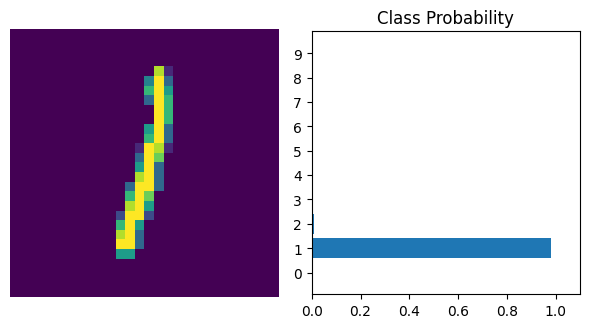

In [34]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Отключаем градиенты, чтобы ускорить эту часть
with torch.no_grad():
    logps = model(img)

# Выход сети — это логарифмические вероятности, необходимо взять экспоненту для получения вероятностей
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps)

Теперь наша сеть может предсказывать цифры на изображениях MNIST. Далее вы напишете код для обучения нейронной сети на более сложном наборе данных.